# Build your own Haiku

In this Colab, we will build a highly-simplified version of Haiku from scratch, to give you some insight into how Haiku works.

This is an "advanced" tutorial for folks seeking a deeper understanding of Haiku's internals. It's not required to understand how to use Haiku in practice. ("advanced" is in quotes because it's not actually all that complicated, so don't be afraid!)

The implementation here is based on the design of the real Haiku library, but with most details simplified. Therefore, while this should give you a reasonably accurate sense of what's going on under-the-hood conceptually, don't rely on the details to match.

## The Problem

We want to be able to write object-oriented classes with parameter attributes, like this,

In [1]:
class MyModule:

  def apply(self, x):
    return self.w * x

and automatically transform them into pure functions, like this:

In [2]:
def my_stateless_apply(params, x):
  return params['w'] * x


(However, instead of using attribute access via `self.*`, we define our own accessor function called `get_param()`. It makes it much easier to intercept its usage, which we need to collect and inject parameter values later.)

Additionally, it would be nice if this transformation also defined parameter initialisation, and automatically handled assigning parameters unique names, as managing that manually in large networks can get unwieldy. E.g., if some other module also called its parameter `w`, we'd like to automatically resolve such conflicts.


We will tackle this problem in steps.

* At the first step, we will implement a basic `transform` that converts object-oriented-style functions into pure ones.
* The next step will be to add the initialisation.
* Finally, we will handle the plumbing involved when several copies of the same module are used, or different modules use the same name for their parameters.

At that stage, we will already be able to define and train a simple neural network just like with the real Haiku.

## The Basic Strategy

We will define a function that implements the transformation from the stateful style that uses `get_param` to a stateless function. This function will be aptly called `transform`. It will wrap a `MyModule().apply` into a function that works just like `my_stateless_apply`.

Here's how it will work. `transform(f)` will return a wrapped version of `f` that accepts an extra `params` argument. When called, it will run `f`, and every time `f` will call `get_param`, it will extract the corresponding value from `params` and return it.

In [3]:
# Global state which holds the parameters for the transformed function.
# get_param uses this to know where to get params from.
current_params = []

def transform(f):

  def apply_f(params, *args, **kwargs):
    current_params.append(params)
    outs = f(*args, **kwargs)
    current_params.pop()
    return outs

  return apply_f


def get_param(identifier):
  return current_params[-1][identifier]

let's test it:

In [4]:
params = dict(w=5)
my_stateless_apply(params, 5)

25

In [5]:
class MyModule:
  def apply(self, x):
    return get_param('w') * x

transform(MyModule().apply)(params, 5)

25

"Hold on!" you say. Isn't JAX all about not having global state? This won't possibly work in JAX! Well, let's try it with JAX:

In [6]:
import jax
import jax.numpy as jnp

def linear(x):
  return x @ get_param('w') + get_param('b')

params = dict(w=jnp.ones((3, 5)), b=jnp.ones((5,)))
apply = transform(linear)

jax.jit(apply)(params, jnp.ones((10, 3)))

DeviceArray([[4., 4., 4., 4., 4.],
             [4., 4., 4., 4., 4.],
             [4., 4., 4., 4., 4.],
             [4., 4., 4., 4., 4.],
             [4., 4., 4., 4., 4.],
             [4., 4., 4., 4., 4.],
             [4., 4., 4., 4., 4.],
             [4., 4., 4., 4., 4.],
             [4., 4., 4., 4., 4.],
             [4., 4., 4., 4., 4.]], dtype=float32)

The reason this works is that while we use global state, we're careful about how we use it. We leave the global state after a function call the same as before it, and we ensure that the outputs of a wrapped function depend only on its inputs. Thus, JAX is none the wiser -- for all it cares, the transformed function is pure.

## Adding initialization

So far, so good, but we aren't able to reuse modules, because our transform will share parameters between all copies of the same module, because they will all be named the same. Also, defining the initial state is a pain -- can we automate that?

Let's tackle initialisation first. For simplicity, our parameters will always initialise using the normal distribution, but it's not hard to add the option of different initialisers.

In this new version, we `transform` one object-oriented stateful function into two pure functions: one which initialises params, and one which applies them. These correspond to running the original function in two modes: initialisation and application. 

To support this, we add extra machinery (the `Frame`) to track which mode we're in, and change the behaviour of `get_param()`:

* We add a `shape` argument, which tells us what shape the param should be if initialising.
* If initialising, `get_param()` will create the param of the correct shape and add it to the current params in the `Frame` before returning.

Thus, `get_param()` generates the initial values just in time for them to get used in a call of the stateful function.

In [7]:
from typing import NamedTuple, Dict, Callable
import numpy as np

In [8]:
# Since we're tracking more than just the current params,
# we introduce the concept of a frame as the object that holds
# state during a transformed execution.
frame_stack = []

class Frame(NamedTuple):
  """Tracks what's going on during a call of a transformed function."""
  params: Dict[str, jax.Array]
  is_initialising: bool = False

def current_frame():
  return frame_stack[-1]


class Transformed(NamedTuple):
  init: Callable
  apply: Callable


def transform(f) -> Transformed:

  def init_f(*args, **kwargs):
    frame_stack.append(Frame({}, is_initialising=True))
    f(*args, **kwargs)
    frame = frame_stack.pop()
    return frame.params

  def apply_f(params, *args, **kwargs):
    frame_stack.append(Frame(params))
    outs = f(*args, **kwargs)
    frame_stack.pop()
    return outs

  return Transformed(init_f, apply_f)

def get_param(identifier, shape):
  if current_frame().is_initialising:
    current_frame().params[identifier] = np.random.normal(size=shape)

  return current_frame().params[identifier]

Let's test it by implementing a Linear module:

In [9]:
# Make printing parameters a little more readable
def parameter_shapes(params):
  return jax.tree_util.tree_map(lambda p: p.shape, params)


class Linear:

  def __init__(self, width):
    self._width = width

  def __call__(self, x):
    w = get_param('w', shape=(x.shape[-1], self._width))
    b = get_param('b', shape=(self._width,))
    return x @ w + b

init, apply = transform(Linear(4))

data = jnp.ones((2, 3))

params = init(data)
parameter_shapes(params)

{'b': (4,), 'w': (3, 4)}

In [10]:
apply(params, data)

DeviceArray([[-1.0345883,  0.3280404, -2.4382973,  0.5717376],
             [-1.0345883,  0.3280404, -2.4382973,  0.5717376]],            dtype=float32)

## Adding unique parameter names: our finished mini-Haiku

Alright! Time to tackle nesting modules, and our prototype will be done.

For this, we need to give each parameter an unambiguous name. Here, we will use a scheme that's somewhat different and incompatible with the real Haiku, but which is simpler. The idea is to record the names of the functions being called, and to assign each parameter a unique identifier based on its location in the call stack.

For this, we will define a Module class. Each module will have a unique identifier based on the class name and the number of instances of the module created so far. (Real Haiku allows to customise these names, but we ignore that for simplicity)

We will also define a decorator for Module methods, called `module_method`, which will tell us when the wrapped function is called, allowing us to track the current parameter scope. Real haiku uses metaclasses to automatically wrap all methods on a `Module`, but for simplicity we do this manually.

In [11]:
import dataclasses
import collections

@dataclasses.dataclass
class Frame:
  """Tracks what's going on during a call of a transformed function."""
  params: Dict[str, jax.Array]
  is_initialising: bool = False

  # Keeps track of how many modules of each class have been created so far.
  # Used to assign new modules unique names.
  module_counts: Dict[str, int] = dataclasses.field(
      default_factory=lambda: collections.defaultdict(lambda: 0))

  # Keeps track of the entire path to the current module method call.
  # Module methods, when called, will add themselves to this stack.
  # Used to give each parameter a unique name corresponding to the
  # method scope it is in.
  call_stack: list = dataclasses.field(default_factory=list)

  def create_param_path(self, identifier) -> str:
    """Creates a unique path for this param."""
    return '/'.join(['~'] + self.call_stack + [identifier])

  def create_unique_module_name(self, module_name: str) -> str:
    """Assigns a unique name to the module by appending its number to its name."""
    number = self.module_counts[module_name]
    self.module_counts[module_name] += 1
    return f"{module_name}_{number}"
  
frame_stack = []

def current_frame():
  return frame_stack[-1]


class Module:
  def __init__(self):
    # Assign a unique (for the current `transform` call)
    # name to this instance of the module.
    self._unique_name = current_frame().create_unique_module_name(
        self.__class__.__name__)


def module_method(f):
  """A decorator for Module methods."""
  # In the real Haiku, this doesn't face the user but is applied by a metaclass.

  def wrapped(self, *args, **kwargs):
    """A version of f that lets the frame know it's being called."""
    # Self is the instance to which this method is attached.
    module_name = self._unique_name
    call_stack = current_frame().call_stack
    call_stack.append(module_name)
    call_stack.append(f.__name__)
    outs = f(self, *args, **kwargs)
    assert call_stack.pop() == f.__name__
    assert call_stack.pop() == module_name
    return outs

  return wrapped


def get_param(identifier, shape):
  frame = current_frame()
  param_path = frame.create_param_path(identifier)

  if frame.is_initialising:
    frame.params[param_path] = np.random.normal(size=shape)

  return frame.params[param_path]


class Linear(Module):

  def __init__(self, width):
    super().__init__()
    self._width = width

  @module_method  # Again, this decorator is behind-the-scenes in real Haiku.
  def __call__(self, x):
    w = get_param('w', shape=(x.shape[-1], self._width))
    b = get_param('b', shape=(self._width,))
    return x @ w + b

At this stage, we have replicated some core Haiku functionality, but we still don't have:
* control over initialisation
* rng handling
* state handling (though conceptually that's analogous to parameter handling)
* any kind of validation and error handling
* freezing parameters once they're created
* thread-safety
* JAX transformations inside a transform (e.g. hk.remat)
* JAX control flow inside transforms (e.g. hk.scan)
* last but not least, documentation :)

and lots more. However, the basics work, so we can take our mini-Haiku for a ride:

In [12]:
init, apply = transform(lambda x: Linear(4)(x))

params = init(data)
parameter_shapes(params)

{'~/Linear_0/__call__/b': (4,), '~/Linear_0/__call__/w': (3, 4)}

In [13]:
apply(params, data)

DeviceArray([[-1.1969297,  1.3215988,  5.175427 , -1.9018829],
             [-1.1969297,  1.3215988,  5.175427 , -1.9018829]],            dtype=float32)

Different Modules in a function call all have separate parameters:

In [14]:
class MLP(Module):

  def __init__(self, widths):
    super().__init__()
    self._widths = widths

  @module_method
  def __call__(self, x):
    for w in self._widths:
      out = Linear(w)(x)
      x = jax.nn.sigmoid(out)
    return out

In [15]:
init, apply = transform(lambda x: MLP([3, 5])(x))
parameter_shapes(init(data))

{'~/MLP_0/__call__/Linear_0/__call__/b': (3,),
 '~/MLP_0/__call__/Linear_0/__call__/w': (3, 3),
 '~/MLP_0/__call__/Linear_1/__call__/b': (5,),
 '~/MLP_0/__call__/Linear_1/__call__/w': (3, 5)}

While the same module called in different places reuses parameters:

In [16]:
class ParameterReuseTest(Module):

  @module_method
  def __call__(self, x):
    f = Linear(x.shape[-1])

    x = f(x)
    x = jax.nn.relu(x)
    return f(x)

init, forward = transform(lambda x: ParameterReuseTest()(x))
parameter_shapes(init(data))

{'~/ParameterReuseTest_0/__call__/Linear_0/__call__/b': (3,),
 '~/ParameterReuseTest_0/__call__/Linear_0/__call__/w': (3, 3)}

## Example training loop



In [17]:
import matplotlib.pyplot as plt

In [18]:
# Data: a quadratic curve.
xs = np.linspace(-2., 2., num=128)[:, None]  # Generate array of shape (128, 1).
ys = xs ** 2

# Model
def mlp(x):
  return MLP([128, 128, 1])(x)

init, forward = transform(mlp)
params = init(xs)
parameter_shapes(params)

{'~/MLP_0/__call__/Linear_0/__call__/b': (128,),
 '~/MLP_0/__call__/Linear_0/__call__/w': (1, 128),
 '~/MLP_0/__call__/Linear_1/__call__/b': (128,),
 '~/MLP_0/__call__/Linear_1/__call__/w': (128, 128),
 '~/MLP_0/__call__/Linear_2/__call__/b': (1,),
 '~/MLP_0/__call__/Linear_2/__call__/w': (128, 1)}

In [19]:
# Loss function and update function
def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.003

@jax.jit
def update(params, x, y):
  grads = jax.grad(loss_fn)(params, x, y)
  return jax.tree_util.tree_map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

In [20]:
for _ in range(5000):
  params = update(params, xs, ys)

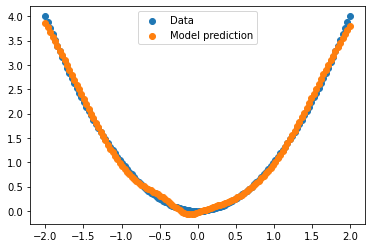

In [21]:
plt.scatter(xs, ys, label='Data')
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend()
plt.show()